In [1]:
from osgeo import gdal,gdal_array
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests,tempfile,os
import numpy as np
import sys,subprocess
import pandas as pd
from math import sqrt,pow

from qgis.core import *
from qgis.analysis import QgsNativeAlgorithms
from qgis.PyQt.QtCore import QVariant

In [2]:
QgsApplication.setPrefixPath(r'C:\OSGeo4W\apps\qgis', True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')


In [3]:
import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
for alg in QgsApplication.processingRegistry().algorithms():
        print(alg.id(), "--->", alg.displayName())

3d:tessellate ---> Tessellate
gdal:aspect ---> Aspect
gdal:assignprojection ---> Assign projection
gdal:buffervectors ---> Buffer vectors
gdal:buildvirtualraster ---> Build virtual raster
gdal:buildvirtualvector ---> Build virtual vector
gdal:cliprasterbyextent ---> Clip raster by extent
gdal:cliprasterbymasklayer ---> Clip raster by mask layer
gdal:clipvectorbyextent ---> Clip vector by extent
gdal:clipvectorbypolygon ---> Clip vector by mask layer
gdal:colorrelief ---> Color relief
gdal:contour ---> Contour
gdal:contour_polygon ---> Contour Polygons
gdal:convertformat ---> Convert format
gdal:dissolve ---> Dissolve
gdal:executesql ---> Execute SQL
gdal:extractprojection ---> Extract projection
gdal:fillnodata ---> Fill nodata
gdal:gdal2tiles ---> gdal2tiles
gdal:gdal2xyz ---> gdal2xyz
gdal:gdalinfo ---> Raster information
gdal:gridaverage ---> Grid (Moving average)
gdal:griddatametrics ---> Grid (Data metrics)
gdal:gridinversedistance ---> Grid (Inverse distance to a power)
gdal:grid

In [4]:
try:
    from whitebox.whitebox_tools import WhiteboxTools
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "whitebox"])

In [5]:
#globaalit
source =r"S:/Luontotieto/QGIS_plugin_test/testitasot.gpkg"
layername="suojakaistaLeim"
testitaso = r'S:/Luontotieto/QGIS_plugin_test/testitasot.gpkg|layername=suojakaistaLeim'
testitaso = QgsVectorLayer(testitaso,"input","ogr")
pnimet = ['suojakaista_taustarasterit','RUSLE','MassataseGISSUS','WB_Finland','DEM'] #taustarastereissa band1 = costdistance ; band2 = euclidean ; band3 = lsn
wbt = WhiteboxTools()

<AxesSubplot:>

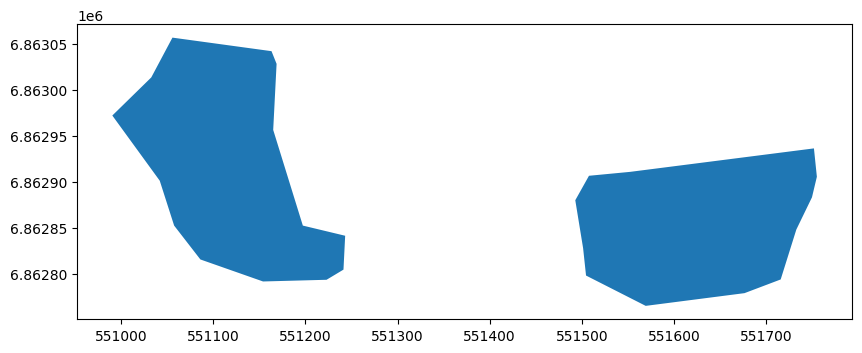

In [6]:
fig,ax = plt.subplots(figsize=(10,10))
gpd.read_file(source,layer=layername).plot(ax=ax)

In [7]:
print (testitaso.extent())

<QgsRectangle: 550990.3125 6862765, 551755.25 6863056.5>


In [8]:
def getBboxWmsFormat(in_feat):
    desc=in_feat.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(in_feat.crs().authid())
    exte = str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)
    witdth = x_max - x_min
    height = y_max - y_min
    
    return exte,srid,witdth,height

In [28]:
def getWater(input_polygon,taso):
    #tempd = tempfile.TemporaryFile()
    #os.makedirs(tempd.name)
    #tempd = tempd.name+'.tif'
    tempd = os.path.dirname(os.path.realpath(input_polygon.sourceName()))
    tempd = os.path.join(tempd,str(taso)+'.tif')
    #tempd = tempd.name+str(taso)+'.tif'
    bbox = getBboxWmsFormat(input_polygon)
    #print (bbox)
    ss = bbox[0].split(',')
    #print (ss)
    wmsurl = 'https://aineistot.metsakeskus.fi/metsakeskus/rest/services/Vesiensuojelu/'+taso+'/ImageServer/exportImage?'
    params = {"bbox":str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1)),
                "bboxSR":3067,
                "size":str((round(int(ss[2])+100,-1)-round(int(ss[0])-100,-1))/2)+","+str((round(int(ss[3])+100,-1) - round(int(ss[1])-100,-1))/2),
                "imageSR":3067,
                "format":'tiff',
                "pixelType":"F32",
                "noData":-9999,
                "noDataInterpretation":"esriNoDataMatchAny",
                "interpolation":"+RSP_BilinearInterpolation",
                "f":"image"}

    #print (params)
    #print (str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1))+" ")
    test = requests.get(wmsurl,params,allow_redirects=True)
    respo = test.content
    open(tempd,"wb").write(respo)
    
    tempd.close()
    

    return tempd

In [10]:
rasterit = []
for i in pnimet:
    rast = getWater(testitaso,i)
    rasterit.append(rast)

print (rasterit)

C:\Users\mkesala\AppData\Local\Temp\ipykernel_18272\1875041431.py:28: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\OSGeo4W\\notebooks\\suojakaista_taustarasterit.tif'>
  open(tempd,"wb").write(respo)
C:\Users\mkesala\AppData\Local\Temp\ipykernel_18272\1875041431.py:28: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\OSGeo4W\\notebooks\\RUSLE.tif'>
  open(tempd,"wb").write(respo)
C:\Users\mkesala\AppData\Local\Temp\ipykernel_18272\1875041431.py:28: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\OSGeo4W\\notebooks\\MassataseGISSUS.tif'>
  open(tempd,"wb").write(respo)
C:\Users\mkesala\AppData\Local\Temp\ipykernel_18272\1875041431.py:28: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\OSGeo4W\\notebooks\\WB_Finland.tif'>
  open(tempd,"wb").write(respo)


['C:\\OSGeo4W\\notebooks\\suojakaista_taustarasterit.tif', 'C:\\OSGeo4W\\notebooks\\RUSLE.tif', 'C:\\OSGeo4W\\notebooks\\MassataseGISSUS.tif', 'C:\\OSGeo4W\\notebooks\\WB_Finland.tif', 'C:\\OSGeo4W\\notebooks\\DEM.tif']


C:\Users\mkesala\AppData\Local\Temp\ipykernel_18272\1875041431.py:28: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\OSGeo4W\\notebooks\\DEM.tif'>
  open(tempd,"wb").write(respo)


In [11]:
def showRaster(raster):
    ds = gdal.Open(raster)
    gt = ds.GetGeoTransform()
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    data = ds.ReadAsArray()
    ds = None
    try:
        data = np.ma.masked_values(data, nodata)
    except:
        data = np.ma.masked_values(data,-9999)
    ys, xs = data.shape
    ulx, xres, _, uly, _, yres = gt
    extent = [ulx, ulx+xres*xs, uly, uly+yres*ys]

    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True, facecolor='w', dpi=86)

    cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis
    cmap.set_bad('#dddddd')

    im = ax.imshow(data, extent=extent, cmap=cmap)
    cb = fig.colorbar(im, shrink=.5)
    cb.set_label('Bathymetry [m]')

In [13]:
def my_callback(value):
    if not "%" in value:
        print(value)

In [14]:
def wbtBreachDepression(dem):
    #wbt = WhiteboxTools()
    output = os.path.dirname(os.path.realpath(dem))
    output = os.path.join(output,"dem_br.tif")
    
    wbt.breach_depressions(
        dem,
        output,
        max_depth=None,
        max_length=None,
        flat_increment=None,
        fill_pits=False,
        callback=my_callback
    )
    
    return output

In [15]:
def wbtD8Pointer(dem):
    output = os.path.dirname(os.path.realpath(dem))
    output = os.path.join(output,"d8_br.tif")
    
    wbt.d8_pointer(
        dem, 
        output,
        esri_pntr = True,
        callback=my_callback
        )
    return output

In [15]:
dem_bd = wbtBreachDepression(rasterit[4])

.\whitebox_tools.exe --run="BreachDepressions" --dem='C:\OSGeo4W\notebooks\DEM.tif' --output='C:\OSGeo4W\notebooks\dem_br.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.51s


C:\OSGeo4W\apps\Python39\lib\subprocess.py:1052: ResourceWarning: subprocess 18320 is still running
  _warn("subprocess %s is still running" % self.pid,
C:\OSGeo4W\apps\Python39\lib\site-packages\whitebox\whitebox_tools.py:4763: ResourceWarning: unclosed file <_io.TextIOWrapper name=5 encoding='UTF-8'>
  return self.run_tool('breach_depressions', args, callback) # returns 1 if error


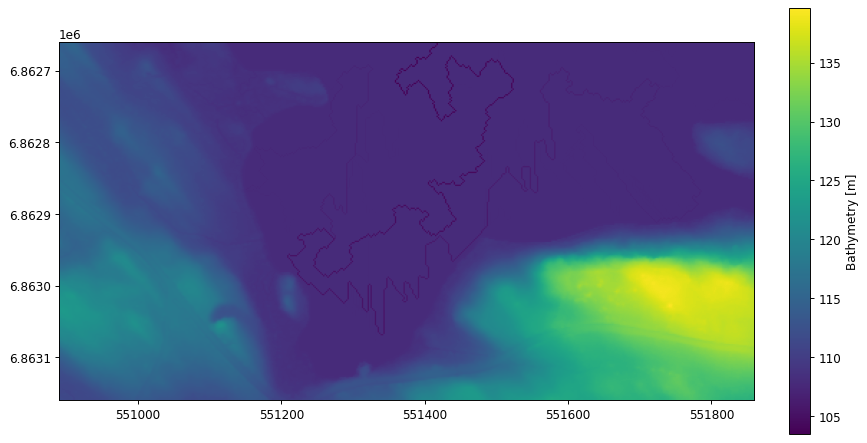

In [16]:
showRaster(dem_bd)

In [17]:
d8 = wbtD8Pointer(dem_bd)

.\whitebox_tools.exe --run="D8Pointer" --dem='C:\OSGeo4W\notebooks\dem_br.tif' --output='C:\OSGeo4W\notebooks\d8_br.tif' --esri_pntr -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.134s


C:\OSGeo4W\apps\Python39\lib\subprocess.py:1052: ResourceWarning: subprocess 8104 is still running
  _warn("subprocess %s is still running" % self.pid,
C:\OSGeo4W\apps\Python39\lib\site-packages\whitebox\whitebox_tools.py:4881: ResourceWarning: unclosed file <_io.TextIOWrapper name=5 encoding='UTF-8'>
  return self.run_tool('d8_pointer', args, callback) # returns 1 if error


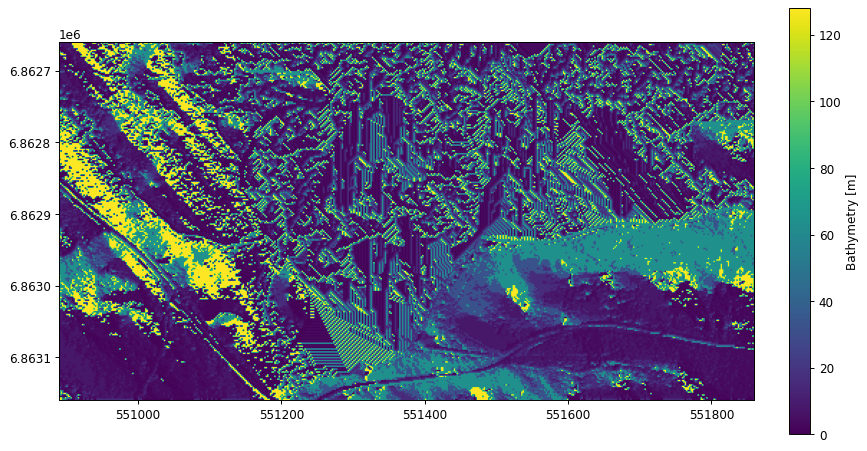

In [18]:
showRaster(d8)

In [16]:
def calcFocal(in_array,etai):

    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    for i in range(0-etai,etai):
        for j in range(0-etai,etai):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=etai:
                ijlist.append((i,j))
    
    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t

In [17]:
def processRaster(input):
    
    rastOut = input[0:-4]+"hh.tif"
    rast = gdal.Open(input)
    
    rastb = rast.GetRasterBand(1)
    rastA = rastb.ReadAsArray()
    rastA = np.where(rastA>0,rastA,0)
    

    focal = calcFocal(rastA,2)
    #huip = focal - chmA
    huip = np.where(focal-rastA==2,1,0)
    #huip = np.where(huip>=5,huip*10,np.NaN)
    #print (huip)
    #print (np.max(huip))
    gdal_array.SaveArray(huip.astype("float32"),rastOut,"GTiff",rast)
    #gdal.Open(rastOut).GetRasterBand(1).SetNoDataValue(-9999)
    
    return rastOut

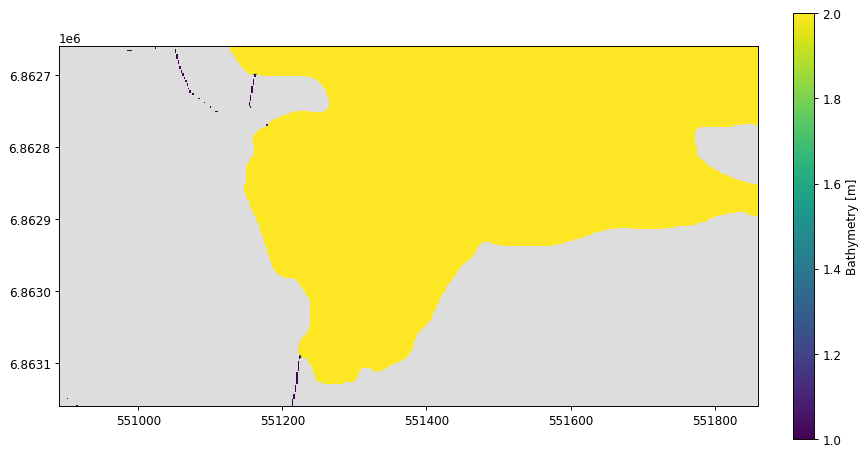

In [17]:
showRaster(rasterit[3])

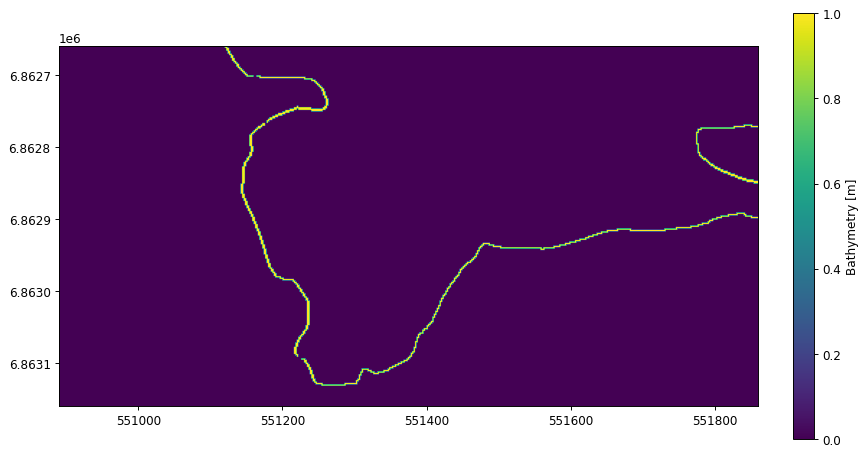

In [24]:
lraster = processRaster(rasterit[3])
#print (lraster)
showRaster(lraster)

In [18]:
def wbtWatershed(d8,pour_pts):
    output = os.path.dirname(os.path.realpath(d8))
    output = os.path.join(output,"watershed.tif")
    wbt.watershed(
        d8, 
        pour_pts, 
        output, 
        esri_pntr=True, 
        callback=my_callback
    )
    outp
    return output

In [26]:
waters = wbtWatershed(d8,lraster)

.\whitebox_tools.exe --run="Watershed" --d8_pntr='C:\OSGeo4W\notebooks\d8_br.tif' --pour_pts='C:\OSGeo4W\notebooks\WB_Finlandhh.tif' --output='C:\OSGeo4W\notebooks\watershed.tif' --esri_pntr -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.135s


C:\OSGeo4W\apps\Python39\lib\subprocess.py:1052: ResourceWarning: subprocess 12508 is still running
  _warn("subprocess %s is still running" % self.pid,
C:\OSGeo4W\apps\Python39\lib\site-packages\whitebox\whitebox_tools.py:5773: ResourceWarning: unclosed file <_io.TextIOWrapper name=5 encoding='UTF-8'>
  return self.run_tool('watershed', args, callback) # returns 1 if error


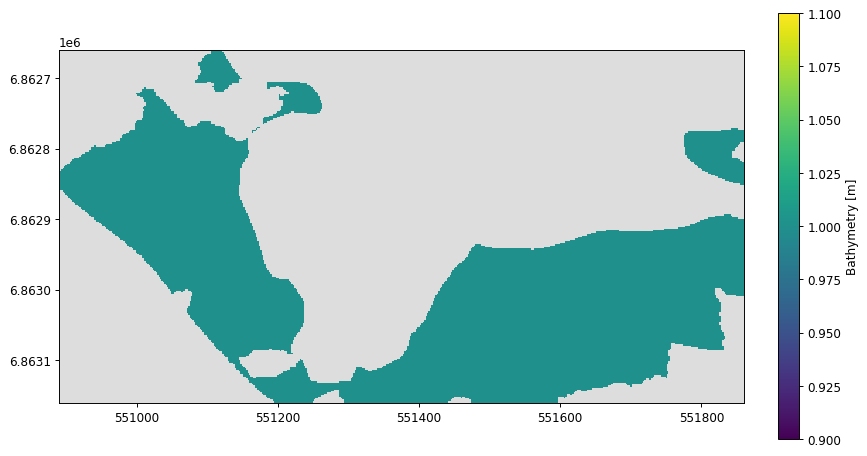

In [27]:
showRaster(waters)

In [19]:
def rasterizeVector(in_layer,cells):
    #print ("jee")
    output = os.path.dirname(os.path.realpath(in_layer.sourceName()))
    output = os.path.join(output,"rasterized.tif")

    bbox = getBboxWmsFormat(in_layer)
    ss = bbox[0].split(',')
    extent = str(round(int(ss[0])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[3])+100,-1))+" ["+str(bbox[1])+"]"
    processing.run("gdal:rasterize",
                        {'INPUT':in_layer,
                        'FIELD':'',
                        'BURN':1,
                        'USE_Z':False,
                        'UNITS':1,
                        'WIDTH':cells,
                        'HEIGHT':cells,
                        'EXTENT':extent,
                        'NODATA':0,
                        'OPTIONS':'',
                        'DATA_TYPE':5,
                        'INIT':None,
                        'INVERT':False,
                        'EXTRA':'',
                        'OUTPUT':output})

    return output

In [20]:
def raster2Array(in_raster,band):
    rast = gdal.Open(in_raster)
    rastB = rast.GetRasterBand(band)
    rastA = rastB.ReadAsArray()

    return rastA

In [30]:
def clipRaster(in_raster,clip_raster):
    
    output = os.path.dirname(os.path.realpath(in_raster))
    output = os.path.join(output,"clipped.tif")
    
    
    in_arr = raster2Array(in_raster,1)
    cl_arr = raster2Array(clip_raster,1)
    
    in_arr = np.where(cl_arr>0,in_arr,0)
    
    gdal_array.SaveArray(in_arr.astype("float32"),output,"GTiff",in_raster)
    
    return output
    

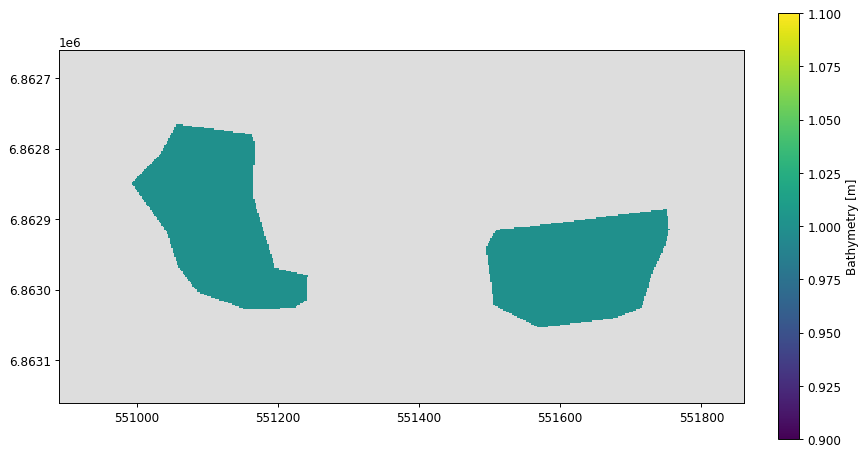

In [31]:
leimraster = rasterizeVector(testitaso,2)
showRaster(leimraster)

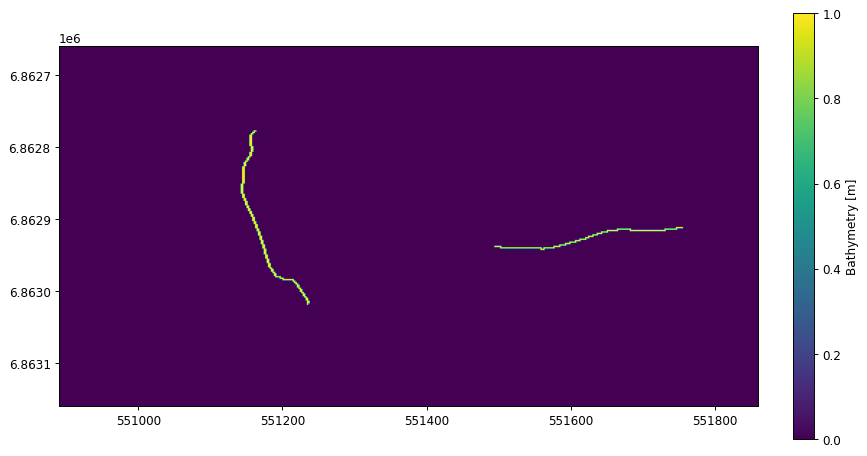

In [32]:
lrast_clip = clipRaster(lraster,leimraster)
showRaster(lrast_clip)

.\whitebox_tools.exe --run="Watershed" --d8_pntr='C:\OSGeo4W\notebooks\d8_br.tif' --pour_pts='C:\OSGeo4W\notebooks\clipped.tif' --output='C:\OSGeo4W\notebooks\watershed.tif' --esri_pntr -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.98s


C:\OSGeo4W\apps\Python39\lib\subprocess.py:1052: ResourceWarning: subprocess 16160 is still running
  _warn("subprocess %s is still running" % self.pid,


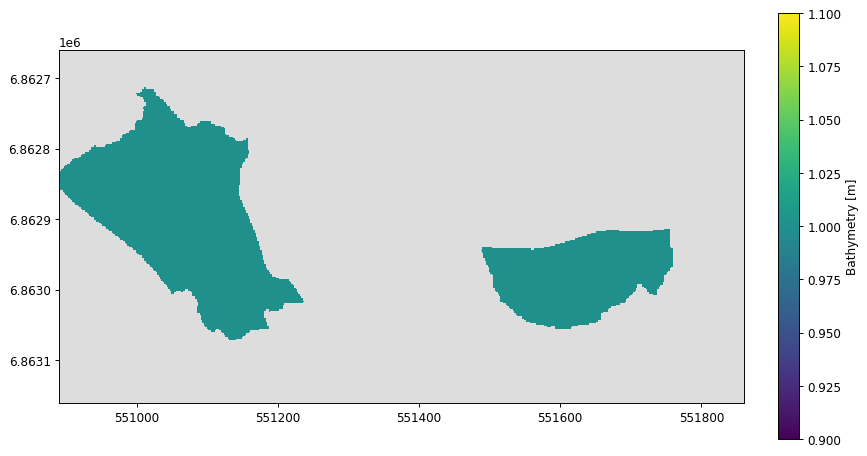

In [33]:
waters_leim = wbtWatershed(d8,lrast_clip)
showRaster(waters_leim)

In [21]:
def loggingEffect(rusle,ls,zoneA,zoneB):

    logging = avoidedMassflux(rusle,ls,zoneA)
    #print (logging)
    bzone = avoidedMassflux(rusle,ls,zoneB)

    acc_max = logging[1] #accumulation max
    ret_max = logging[1] - logging[0] #retention max (accumalation max - natural accumulation)
    acc_nat = logging[0] #natural accumulation
    acc_bz = logging[1] - bzone[1] + bzone[0] #accumulation with buffer zone (accumulation max - accumulation max in buffer zone + accumulation in buffer zone)
    acc_res = logging[1]- (logging[1] - bzone[1] + bzone[0]) #reserved accumulation (accumulation max - accumulation with buffer zone)
    acc_add = ret_max - acc_res #added accumulation (retention max - reserved accumulation)
    eff_res = round(100 -acc_add / acc_max * 100,1) #effect of reserved accumulation (%) (reserved accumulation / retention max * 100)
    
    #print (acc_max,ret_max,acc_nat,acc_bz,acc_res,acc_add,eff_res)
    return(acc_max,ret_max,acc_nat,acc_bz,acc_res,acc_add,eff_res)

In [22]:
def raster2vector(in_rast,data):
    
    vectn = processing.run("gdal:polygonize", 
        {'INPUT':in_rast,
        'BAND':1,
        'FIELD':'DN',
        'EIGHT_CONNECTEDNESS':False,
        'EXTRA':'',
        'OUTPUT':'TEMPORARY_OUTPUT'})
    
    vect = QgsVectorLayer(vectn['OUTPUT'],"vyohyke","ogr")
    
    namelist = list(data.columns)
    for i in namelist:
        vect.dataProvider().addAttributes([QgsField(i,QVariant.Double)])
        vect.updateFields()
    
    with edit(vect):
        for feat in vect.getFeatures():
            if feat['DN'] == 0:
                vect.deleteFeature(feat.id())

            for i in namelist:
                datac = data[[i]]
                #print (datac.iloc[0,0])
                feat[i] = float(datac.iloc[0,0])
            
            geom = feat.geometry()
            buffer = geom.buffer(10, 5)
            buffer = buffer.buffer(-10,5)
            feat.setGeometry(buffer)

            vect.updateFeature(feat)
    
    return vect


In [23]:
def array2raster(in_array,map_raster):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.tif'
    
    gdal_array.SaveArray(in_array.astype("float32"),tempd,"GTiff",map_raster)

    return tempd

In [24]:
def massfluxgraph(all):
    graafi = tempfile.TemporaryFile()
    graafi = graafi.name+'.png'

    plt.clf()
    plt.bar(all['area_ratio'],all['effect_bufferzone'])
    plt.xlabel("Area coverage (%)")
    plt.ylabel("Avoided massflux (%)")
    plt.savefig(graafi, dpi=150)
    
    return graafi

In [25]:
def avoidedMassflux(rusle,ls,zone):
    
    rusleA = raster2Array(rusle,1)
    rusleA = np.where(rusleA>0,rusleA,0.1)
    rusleA = rusleA / 1000
    lsA = raster2Array(ls,3)
    lsA = np.where(lsA>0,lsA,0.1)
    lsA = lsA/100*rusleA
    #print(rusleA-lsA/100)
    #zoneA = raster2Array(zone,1)
    sum_rusle = np.where(zone>0,rusleA,0)
    sum_ls = np.where(zone>0,lsA,0)
    rus = np.sum(sum_rusle)
    amf = np.sum(sum_ls)

    return amf,rus

In [120]:
for i in range (100,0,-5):
    print (i)

100
95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5


In [26]:
def loggingZone(logging,rasters):
    
    
    lraster = rasterizeVector(logging,2)
    
  
    wline = processRaster(rasters[3])
    lrast_clip = clipRaster(wline,lraster)

    lraster = raster2Array(lraster,1)
    
    #print (rasters[4])
    dem_bd = wbtBreachDepression(rasters[4])
    
    d8 = wbtD8Pointer(dem_bd)
    waters = wbtWatershed(d8,lrast_clip)
    
    
    
    wshed_arr = raster2Array(waters,1)
    #wshed_arr = np.where((wshed_arr>0) or (r))
    lzone = np.where((lraster!=0) & (wshed_arr>0),1,0)
    
    return lzone
    

In [27]:
lzone = loggingZone(testitaso,rasterit)

NameError: name 'clipRaster' is not defined

In [34]:
print (np.sum(lzone))

14586


In [88]:
def bufferZone(lzone,rasters,target):
    d1=[]
    arl =[]
    t = 0
    zraster = raster2Array(rasters[0],1)
    #print (zraster)
    for i in range(0,105,5):
        zzone = []
        z=[]
        
        zzone = np.where((lzone==1),zraster,0)
        
        z = zzone[zzone>0]
        #print (z)
        z = np.percentile(z,i)
        #print (z,np.sum(zzone))
        
        zzone = np.where((zzone<z) & (lzone > 0) & (zzone>0),1,0)
        
        effect = loggingEffect(rasters[1],rasters[0],lzone,zzone)
        ar = round(float((np.sum(zzone) / np.sum(lzone) * 100)),1)
        d1.append(effect)
        arl.append(ar)
        print (effect)
        
        if (effect[6] > target and t == 0):
            t = 1
            effect_c = effect
            ar_c = ar
            zzone_c = zzone
    
    
    #print (d1)
    bzone = array2raster(zzone_c,rasters[1])
    
    
   
    
    dataset = {'massflux_max':[effect_c[0]],
                'retention_max':[effect_c[1]],
                'natural_massflux':[effect_c[2]],
                'massflux_bufferzone':[effect_c[3]],
                'massflux_reserved':[effect_c[4]],
                'massflux_added':[effect_c[5]],
                'effect_bufferzone':[effect_c[6]],
                'area_ratio':ar_c}
    
   
    dataset_all = {'massflux_max':[i[0] for i in d1],
                'retention_max':[i[1] for i in d1],
                'natural_massflux':[i[2] for i in d1],
                'massflux_bufferzone':[i[3] for i in d1],
                'massflux_reserved':[i[4] for i in d1],
                'massflux_added':[i[5] for i in d1],
                'effect_bufferzone':[i[6] for i in d1],
                'area_ratio':arl}

    df = pd.DataFrame(dataset)
    df_all = pd.DataFrame(dataset_all)

    fig = massfluxgraph(df_all)
    
    #return bzone
    res = raster2vector(bzone,df)
    gpd.read_file(res.source(),layer=res.sourceName()).plot(ax=ax)

    return res,fig

(2764.0886, 1776.7976, 987.2911, 2764.0886, 0.0, 1776.7976, 35.7)
(2764.0886, 1776.7976, 987.2911, 2654.14, 109.94873, 1666.8489, 39.7)
(2764.0886, 1776.7976, 987.2911, 2525.1907, 238.89795, 1537.8997, 44.4)
(2764.0886, 1776.7976, 987.2911, 2407.2214, 356.8672, 1419.9304, 48.6)
(2764.0886, 1776.7976, 987.2911, 2283.7263, 480.3623, 1296.4353, 53.1)
(2764.0886, 1776.7976, 987.2911, 2165.0957, 598.9929, 1177.8047, 57.4)
(2764.0886, 1776.7976, 987.2911, 2054.7383, 709.35034, 1067.4473, 61.4)
(2764.0886, 1776.7976, 987.2911, 1945.146, 818.9426, 957.855, 65.3)
(2764.0886, 1776.7976, 987.2911, 1840.2708, 923.8179, 852.97974, 69.1)
(2764.0886, 1776.7976, 987.2911, 1729.7488, 1034.3398, 742.45776, 73.1)
(2764.0886, 1776.7976, 987.2911, 1619.3142, 1144.7744, 632.0232, 77.1)
(2764.0886, 1776.7976, 987.2911, 1508.6943, 1255.3943, 521.4033, 81.1)
(2764.0886, 1776.7976, 987.2911, 1406.4568, 1357.6318, 419.16577, 84.8)
(2764.0886, 1776.7976, 987.2911, 1319.4257, 1444.663, 332.13464, 88.0)
(2764.0886,

C:\Users\mkesala\AppData\Local\Temp\ipykernel_14048\2452465168.py:3: ResourceWarning: unclosed file <_io.BufferedRandom name=5>
  tempd = tempd.name+'.tif'


ValueError: Null layer: 'vyohyke'

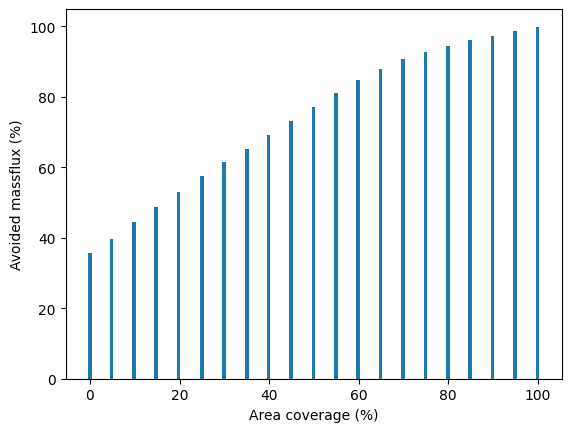

In [89]:
test = bufferZone(lzone,rasterit,50)

In [87]:
#rint (test)
#showRaster(test)
#showRaster(test[1])
#print (test[0].source())
#fix,ax = plt.subplots(figsize=(10,10))
gpd.read_file(test[0].source(),layer=test[0].sourceName()).plot(ax=ax)

ValueError: Null layer: 'vyohyke'